In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect
from datetime import timedelta

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
Base = automap_base()
# reflect an existing database into a new model
Base.prepare(autoload_with= engine)
# reflect the tables


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
#inputting into pandas for easier usage
measure = pd.read_sql_table(table_name = "measurement", con = engine)
stat = pd.read_sql_table(table_name = "station", con = engine)

In [12]:
# Find the most recent date in the data set.
measure["date"] = pd.to_datetime(measure["date"]).dt.date # turning into dates for easier manipulation
latest = measure["date"].max()
latest

datetime.date(2017, 8, 23)

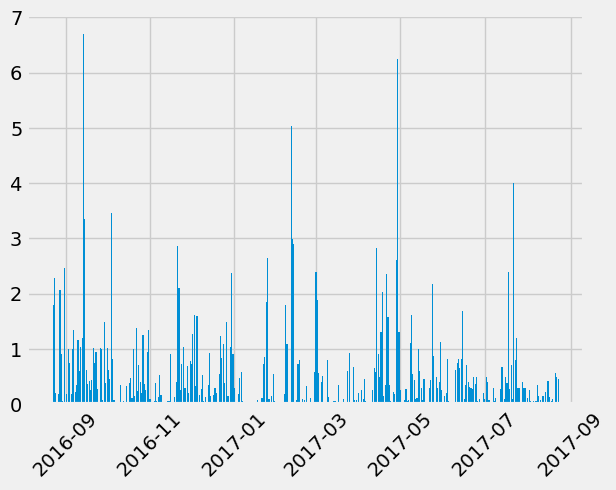

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
prv_year =latest-timedelta(days =365)
prv_year
# Perform a query to retrieve the data and precipitation scores
measure_filter = measure[measure["date"]>= prv_year]
measure_filter

# Save the query results as a Pandas DataFrame. Explicitly set the column names
#oops... see previous bullet

# Sort the dataframe by date
measure_filter.sort_values(by = "date", ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(x = measure_filter["date"], height = measure_filter["prcp"])
plt.xticks(rotation=45)
plt.show()

In [14]:
measure_filter

,id,station,date,prcp,tobs
2363,2364,USC00519397,2016-08-23,0.00,81.0
2364,2365,USC00519397,2016-08-24,0.08,79.0
2365,2366,USC00519397,2016-08-25,0.08,80.0
2366,2367,USC00519397,2016-08-26,0.00,79.0
2367,2368,USC00519397,2016-08-27,0.00,77.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
measure_filter[["prcp"]].describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
# let's use alchemy... that was the purpose of this assignment
session.query(station).count()

9

In [18]:
inspector = inspect(engine)

In [19]:
for x in inspector.get_columns("station"): 
    print(x)
#The keys in this dataset is "name"

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}


In [20]:
for x in inspector.get_columns("station"): 
    print(x["name"])

id
station
name
latitude
longitude
elevation


In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(measurement.station, func.count(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
max_temp = session.query(measurement.station, func.max(measurement.tobs)).group_by(measurement.station).\
filter(measurement.station=="USC00519281").all()
min_temp = session.query(measurement.station, func.min(measurement.tobs)).group_by(measurement.station).\
filter(measurement.station=="USC00519281").all()
avg_temp = session.query(measurement.station, func.avg(measurement.tobs)).group_by(measurement.station).\
filter(measurement.station=="USC00519281").all()

print(f"Max temp was {max_temp[0][1]}, Min temp was {min_temp[0][1]}, avg temp was {avg_temp[0][1]}")


Max temp was 85.0, Min temp was 54.0, avg temp was 71.66378066378067


In [23]:
session.query(measurement.station, func.max(measurement.date)).group_by(measurement.station).\
filter(measurement.station=="USC00519281").all()

[('USC00519281', '2017-08-18')]

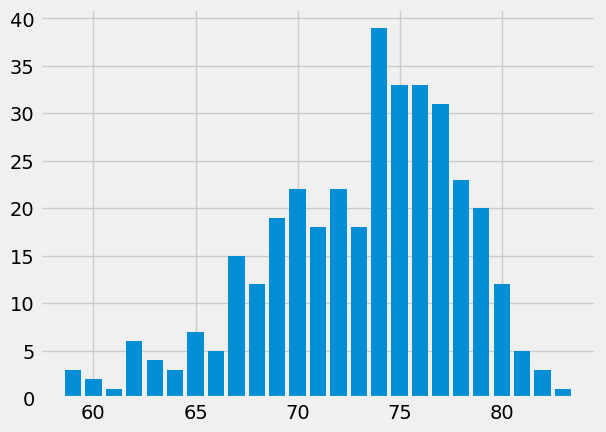

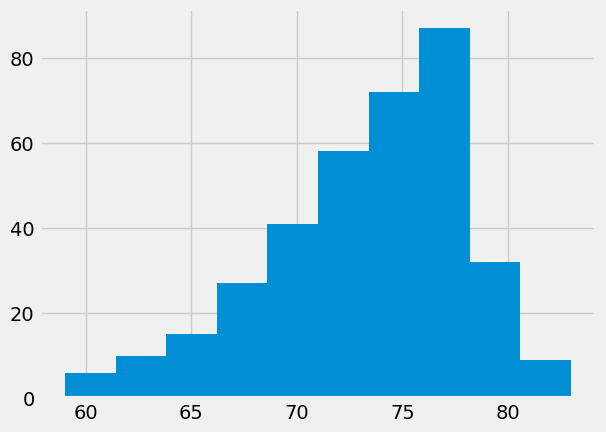

In [62]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_list = []
temp_count = []


temp_freq = session.query(measurement.tobs, func.count(measurement.tobs)).group_by(measurement.tobs).\
filter(measurement.date>="2016-08-18", measurement.station=="USC00519281").all()

temp_freq2 = session.query(measurement.tobs).filter(measurement.date>="2016-08-18", measurement.station=="USC00519281").all()

hist = [x[0] for x in temp_freq2]
for x in temp_freq:
    temp_list.append(x[0])
    temp_count.append(x[1])


plt.bar(x = temp_list, height = temp_count)

plt.show()

plt.hist(hist)

plt.show()


# Close Session

In [26]:
# Close Session
session.close()